In [3]:
%matplotlib inline
import time
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy import io
import pickle

# Own code
sys.path.append("../")
from utils.data_utils import generate_contemp_matrices, transformation, standardize
from utils.tvp_models import tvp_ar_non_contemp

# Suppress scientific notation in numpy
np.set_printoptions(suppress=True)

In [26]:
transform = True

ds = pd.read_csv("../data/fred_qd.csv")
gdp = transformation(ds["GDPC1"].iloc[2:].to_numpy(), 5, transform, scale=1)
cpi = transformation(ds["CPIAUCSL"].iloc[2:].to_numpy(), 6, transform, scale=1)
fedfund = transformation(ds["FEDFUNDS"].iloc[2:].to_numpy(), 2, transform, scale=1)
compi = transformation(ds["PPIACO"].iloc[2:].to_numpy(), 6, transform, scale=1)
borrowings = transformation(ds["TOTRESNS"].iloc[2:].to_numpy(), 6, transform, scale=1)
sp500 = transformation(ds["S&P 500"].iloc[2:].to_numpy(), 5, transform, scale=1)
m2 = transformation(ds["M2REAL"].iloc[2:].to_numpy(), 5, transform, scale=1)

# Start due to transformation

lag = 1

series = [gdp[lag:], cpi[lag:], fedfund[lag:]]

# standardized = standardize(series, train = 243-25)

series_total = np.array(series)

y_matrix_contemp, X_matrix_contemp = generate_contemp_matrices(244, 3, 1, series_total)

# Lasso 

In [12]:
# Check if the model, given the specific data, converges at all

M = 3
T = 243
p = 1
prior = "lasso_alternative"
train = T - 25

msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=200)

Iteration: 10 
 Elapsed time: 0.4589 seconds
Seconds for one iteration: 0.059
 Difference: 0.003
Seconds for one iteration: 0.0463
 Difference: 0.0013
Seconds for one iteration: 0.0479
 Difference: 0.0005
Seconds for one iteration: 0.0537
 Difference: 0.0002
Progress: 1/26 | Elapsed time: 0.7365341186523438 seconds | Coefficients converged: True
ETA: 2020-11-15 18:03:27.277440
Progress: 2/26 | Elapsed time: 0.7886049747467041 seconds | Coefficients converged: True
ETA: 2020-11-15 18:03:28.579411
Progress: 3/26 | Elapsed time: 0.8136341571807861 seconds | Coefficients converged: True
ETA: 2020-11-15 18:03:29.180289
Progress: 4/26 | Elapsed time: 0.8770978450775146 seconds | Coefficients converged: True
ETA: 2020-11-15 18:03:30.640118
Progress: 5/26 | Elapsed time: 0.8530731201171875 seconds | Coefficients converged: True
ETA: 2020-11-15 18:03:30.111754
Progress: 6/26 | Elapsed time: 0.8861579895019531 seconds | Coefficients converged: True
ETA: 2020-11-15 18:03:30.806711
Progress: 7/26 

### Parameter -> $a_{0}$

In [ ]:
def calculate_derivative_lasso_a0(iteration, parameter_value):
    
    M = 3
    prior = "lasso_alternative"
    T = 243
    p = 1
    train = T-25
    iterations = 100

    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0_lasso":parameter_value+error,"b0_lasso":1e-3}
    prior_parameters_minus = {"a0_lasso":parameter_value-error,"b0_lasso":1e-3}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-3
finish = 2
interval = 256

a0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_lasso_a0, a0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 256) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "lasso_alternative"
parameter = "a0_lasso"
start = 1e-3
finish = 2
interval = 256

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $b_{0}$

In [ ]:
def calculate_derivative_lasso_b0(iteration, parameter_value):
    
    M = 3
    prior = "lasso_alternative"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0_lasso":1e-3,"b0_lasso":parameter_value+error}
    prior_parameters_minus = {"a0_lasso":1e-3,"b0_lasso":parameter_value-error}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-3
finish = 1e-2
interval = 128

b0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_lasso_b0, b0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "lasso_alternative"
parameter = "b0_lasso"
start = 1e-3
finish = 1e-2
interval = 128

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

# SVSS

In [ ]:
# Check if the model, given the specific data, converges at all

M = 3
T = 243
p = 1
prior = "svss"
train = T - 25

msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=200)

### Parameter -> $g_{0}$

In [35]:
def calculate_derivative_svss_g0(iteration, parameter_value):
    
    M = 3
    prior = "svss"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"g0":parameter_value+error,"h0":1e-2, "pi0":0.5}
    prior_parameters_minus = {"g0":parameter_value-error,"h0":1e-2, "pi0":0.5}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [37]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-2
finish = 1e-1
interval = 64

g0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_svss_g0, g0_set)

Run: 16 -> Derivative: 7.129747614809773e-05
Run: 15 -> Derivative: 7.194790926383477e-05
Run: 6 -> Derivative: 8.284309812583853e-05
Run: 7 -> Derivative: 8.063327952626964e-05
Run: 8 -> Derivative: 7.892561348598306e-05
Run: 5 -> Derivative: 8.773495059399834e-05
Run: 9 -> Derivative: 7.752079373556667e-05
Run: 10 -> Derivative: 7.634364625058245e-05
Run: 4 -> Derivative: 0.00010802755410832837
Run: 3 -> Derivative: 0.00015870137985559953
Run: 11 -> Derivative: 7.533264245657288e-05
Run: 2 -> Derivative: 0.00017366225121421663
Run: 1 -> Derivative: 0.00010335758492682112
Run: 17 -> Derivative: 7.068020561079816e-05
Run: 14 -> Derivative: 7.267244130795074e-05
Run: 12 -> Derivative: 7.444196672148224e-05
Run: 13 -> Derivative: 7.340838591023222e-05
Run: 18 -> Derivative: 7.009378206042419e-05
Run: 19 -> Derivative: 6.953316081546788e-05
Run: 20 -> Derivative: 6.899023730563779e-05
Run: 22 -> Derivative: 6.795582949741926e-05
Run: 21 -> Derivative: 6.846236514063468e-05
Run: 23 -> Deri

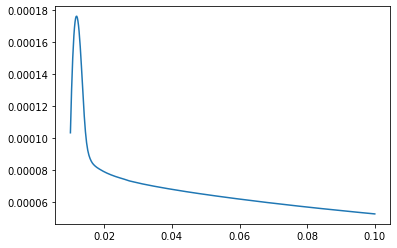

In [41]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [42]:
prior = "svss"
parameter = "g0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $h_{0}$

In [43]:
def calculate_derivative_svss_h0(iteration, parameter_value):
    
    M = 3
    prior = "svss"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"g0":1e-2,"h0":parameter_value+error, "pi0":0.5}
    prior_parameters_minus = {"g0":1e-2,"h0":parameter_value-error, "pi0":0.5}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [44]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-2
finish = 1e-1
interval = 64

h0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_svss_h0, h0_set)

Run: 12 -> Derivative: -0.0026646228533136963
Run: 13 -> Derivative: -0.002683261049392512
Run: 11 -> Derivative: -0.002648323818160325
Run: 14 -> Derivative: -0.002702616334542727
Run: 9 -> Derivative: -0.0026141217045334507
Run: 10 -> Derivative: -0.0026308794749052575
Run: 8 -> Derivative: -0.0026195113264769598
Run: 15 -> Derivative: -0.002722778189836335
Run: 7 -> Derivative: -0.0030601497010489935
Run: 16 -> Derivative: -0.0027437882132208516
Run: 6 -> Derivative: -0.0031181527874297285
Run: 3 -> Derivative: -0.0030029051362877803
Run: 2 -> Derivative: -0.0037244272422371476
Run: 5 -> Derivative: -0.003097271940971694
Run: 4 -> Derivative: -0.003079604143135734
Run: 1 -> Derivative: -0.004095649476064758
Run: 17 -> Derivative: -0.002765549728750658
Run: 18 -> Derivative: -0.0027883880770331678
Run: 30 -> Derivative: -0.0024434407773907306
Run: 29 -> Derivative: -0.002454049494502841
Run: 28 -> Derivative: -0.0024634564196203052
Run: 27 -> Derivative: -0.0024717301934915102
Run: 2

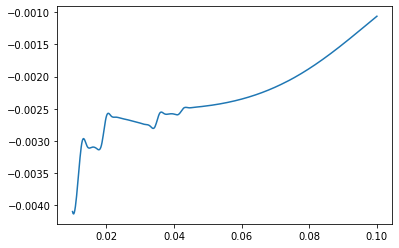

In [45]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [46]:
prior = "svss"
parameter = "h0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

# Horseshoe

In [42]:
# Check if the model, given the specific data, converges at all

M = 3
T = 243
p = 1
prior = "horseshoe"
train = T - 25

prior_parameters = {"a0":10,"b0":10}

msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=100, prior_parameters=prior_parameters)

Iteration: 40 
 Elapsed time: 0.5264 seconds
lambda: 0.37238205828113324,phi: 2.0562938467921867, v: 1.1374594840751673, delta: 1.4098049474968166 mt1t: 0.07379247685074032
Seconds for one iteration: 0.0562
 Difference: 0.0004
lambda: 0.37238003826769495,phi: 2.0562898650355335, v: 1.137459578159065, delta: 1.4098064857007504 mt1t: 0.07379168948916609
Seconds for one iteration: 0.0529
 Difference: 0.0003
lambda: 0.372381610324499,phi: 2.0562929663568075, v: 1.1374595049533662, delta: 1.4098052895677713 mt1t: 0.07379230695576466
Seconds for one iteration: 0.0554
 Difference: 0.0003
lambda: 0.3723803851288003,phi: 2.05629054744865, v: 1.1374595619968109, delta: 1.4098062210730244 mt1t: 0.0737918224097239
Seconds for one iteration: 0.0513
 Difference: 0.0002
lambda: 0.3723813412473888,phi: 2.0562924364371575, v: 1.1374595174881346, delta: 1.409805494642722 mt1t: 0.07379220287598265
Seconds for one iteration: 0.0538
 Difference: 0.0002
lambda: 0.3723805941998465,phi: 2.0562909595509535, v:

In [40]:
msfe.mean()

0.01449594737326167

### Parameter -> $a_{0}$

In [ ]:
def calculate_derivative_horseshoe_a0(iteration, parameter_value):
    
    M = 3
    prior = "horseshoe"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0":parameter_value+error,"b0":1}
    prior_parameters_minus = {"a0":parameter_value-error,"b0":1}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1/2
finish = 2
interval = 64

a0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_horseshoe_a0, a0_set)

In [ ]:
prior = "horseshoe"
parameter = "a0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

### Parameter -> $b_{0}$

In [ ]:
def calculate_derivative_horseshoe_b0(iteration, parameter_value):
    
    M = 3
    prior = "horseshoe"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0":1/2,"b0":parameter_value+error}
    prior_parameters_minus = {"a0":1/2,"b0":parameter_value-error}
    
    msfe_plus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative}')
    
    return [parameter_value, derivative]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1
finish = 5
interval = 64

b0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_horseshoe_b0, b0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "horseshoe"
parameter = "b0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{prior}_{parameter}_{start}_{finish}_{interval}.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)